# Macro Regimes vs Market Stress (CSI)

This notebook compares:
- **Macro regimes** (slow economic state estimation)
- **CSI** (fast market stress detection)

The focus is timing, persistence, and failure modes — not alpha.


In [9]:
import matplotlib.pyplot as plt
from utils.io import load_parquet
from analysis.event_definitions import define_stress_events
from analysis.latency import compute_latency_table
from analysis.conditioning import conditional_forward_metrics

csi_df = load_parquet("processed/csi.parquet")
csi = csi_df["CSI"]
stress_regime = csi_df["stress_regime"]

macro = load_parquet("interim/macro_daily.parquet")
# assume macro_regime already exists or simple proxy:
macro_regime = (macro["CPIAUCSL"].pct_change(12) > 0).astype(int)

In [10]:
events = define_stress_events()
latency = compute_latency_table(events, csi, macro_regime)
latency

,event,type,csi_days_to_trigger,macro_days_to_trigger
0,GFC shock,sudden,0,21
1,Flash Crash,sudden,5,5
2,COVID shock,sudden,9,3
3,GFC prolonged,prolonged,25,5
4,Euro debt,prolonged,34,35
5,Tightening cycle,prolonged,20,4


Note: The macro regime proxy is intentionally simple. The objective is not to optimize macro classification, but to demonstrate structural lag and persistence relative to fast market stress signals.

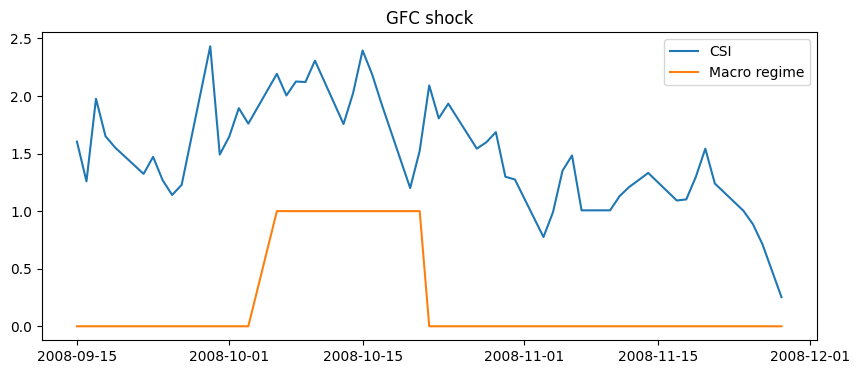

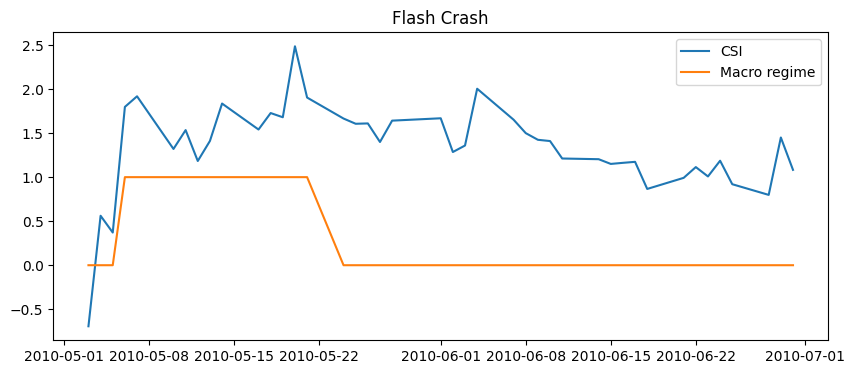

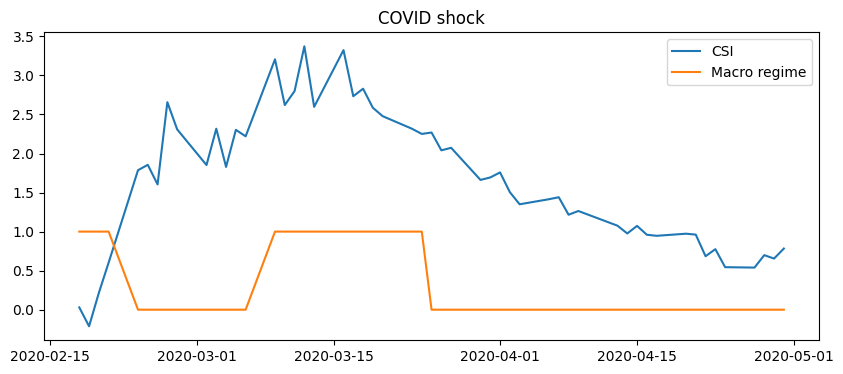

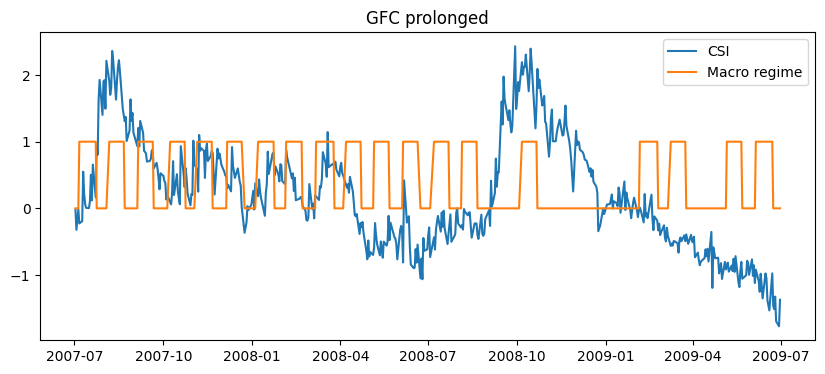

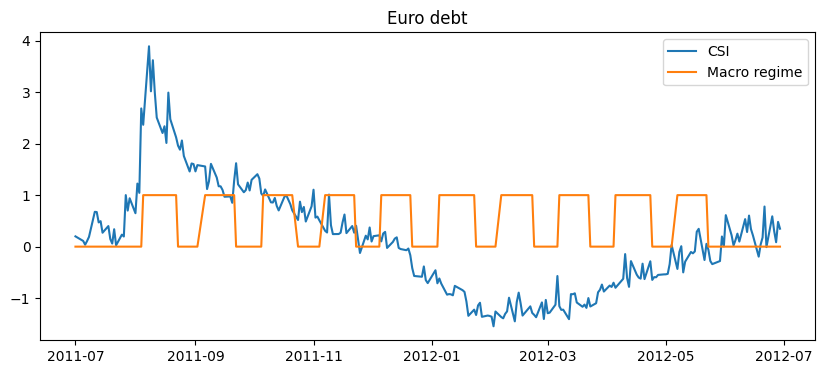

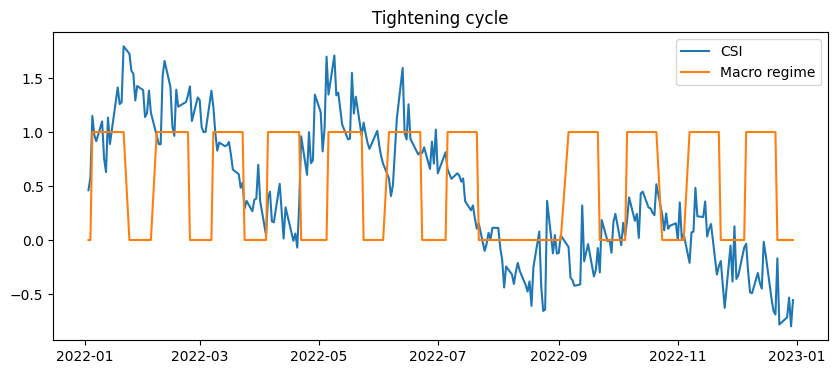

In [11]:
for _, ev in events.iterrows():
    plt.figure(figsize=(10,4))
    plt.plot(csi.loc[ev["start"]:ev["end"]], label="CSI")
    plt.plot(macro_regime.loc[ev["start"]:ev["end"]], label="Macro regime")
    plt.title(ev["label"])
    plt.legend()
    plt.show()

In [12]:
# Use SPY returns
market = load_parquet("interim/market_daily.parquet")
ret = market["close_SPY"].pct_change()

cond = conditional_forward_metrics(ret, stress_regime)
cond

,regime,mean_fwd_return,fwd_vol,downside_prob
0,0.0,0.000246,0.010871,0.450372
1,1.0,0.000557,0.014712,0.456667
2,2.0,0.000966,0.021570,0.480211
